In [50]:
import pandas as pd
import numpy as np
from keras.src.layers import GRU, Dropout, Dense
from keras.src.optimizers import Adam
from keras import Sequential, Input
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from matplotlib import pyplot as plt
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.src.layers import Bidirectional

In [51]:
df = pd.read_csv("../data/processed/price_data.csv")

In [52]:
df.head()

,date,price,temperature,humidity,precipitation,cloud_cover,wind_speed
0,2023-01-01 00:00:00,13.31,6.9,91,0.0,53,20.9
1,2023-01-01 01:00:00,-0.07,6.9,92,0.0,32,20.7
2,2023-01-01 02:00:00,-0.47,8.1,89,0.0,8,23.5
3,2023-01-01 03:00:00,-1.56,7.6,91,0.0,6,22.1
4,2023-01-01 04:00:00,-1.94,7.3,92,0.0,24,21.4


In [53]:
df.isnull().sum()

date             0
price            0
temperature      0
humidity         0
precipitation    0
cloud_cover      0
wind_speed       0
dtype: int64

In [54]:
df.dtypes

date              object
price            float64
temperature      float64
humidity           int64
precipitation    float64
cloud_cover        int64
wind_speed       float64
dtype: object

In [55]:
def create_time_series(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
            X.append(data[i - n_past:i, 0:data.shape[1]])
            y.append(data[i,0])
    return np.array(X),np.array(y)

In [56]:
def create_model(train_input_shape):
    model = Sequential(name='Bidirectional_GRU')
    optimizer = Adam(learning_rate=0.001) 
    
    model.add(Input(shape=(train_input_shape.shape[1], train_input_shape.shape[2])))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(32)))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

In [57]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [58]:
window_size = 24

In [59]:
input_data = df.columns.tolist()
output_data = 'price'

input_data.remove(output_data)
input_data.remove('date')

In [60]:
ig_scores = mutual_info_regression(df[input_data], df[output_data])

feature_scores = pd.DataFrame({'Feature': df[input_data].columns, 'Information_Gain': ig_scores})
feature_scores = feature_scores.sort_values(by='Information_Gain', ascending=False)

feature_scores.reset_index(drop=True, inplace=True)
feature_scores.head()

,Feature,Information_Gain
0,temperature,0.083000
1,humidity,0.023031
2,wind_speed,0.022078
3,cloud_cover,0.006776
4,precipitation,0.003195


In [61]:
output_data = [output_data]
for i in feature_scores['Feature'][:3].tolist():
    output_data.append(i)

In [62]:
input_columns = output_data
df[input_columns].head()

,price,temperature,humidity,wind_speed
0,13.31,6.9,91,20.9
1,-0.07,6.9,92,20.7
2,-0.47,8.1,89,23.5
3,-1.56,7.6,91,22.1
4,-1.94,7.3,92,21.4


In [63]:
filtered_df = df[input_columns]
dataset = filtered_df.values

In [64]:
test_data_size = round(0.2 * len(dataset))

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (9906, 4)
Test data shape: (2477, 4)


In [65]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [66]:
X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [67]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (9882, 24, 4)
Shape of X_test: (2453, 24, 4)
Shape of y_train: (9882,)
Shape of y_test: (2453,)


In [68]:
model = create_model(X_train)

In [69]:
hist = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 0.0249 - val_loss: 8.3074e-04 - learning_rate: 0.0010
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - loss: 0.0018 - val_loss: 7.3043e-04 - learning_rate: 0.0010
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 0.0013 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - loss: 0.0012 - val_loss: 5.5921e-04 - learning_rate: 0.0010
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - loss: 0.0010 - val_loss: 4.8634e-04 - learning_rate: 0.0010
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - loss: 8.7041e-04 - val_loss: 4.5311e-04 - learning_rate: 0.0010
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - loss: 8.8049e-04 - val_loss: 4.0946e-04 - learning_rate: 0.0010
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - loss: 7.5433e-04 - val_loss: 5.5096e-04 - learning_rate: 0.0010
Epoch 9/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step

In [70]:
predicted = model.predict(X_test, verbose=0)

In [71]:
predicted_copy_array = np.repeat(predicted, len(input_columns), axis=-1)
predicted_copy_array.shape

(2453, 4)

In [72]:
pred = scaler.inverse_transform(np.reshape(predicted_copy_array,(len(predicted), len(input_columns))))[:, 0]
actual_copy_array = np.repeat(y_test, len(input_columns), axis=-1)
actual = scaler.inverse_transform(np.reshape(actual_copy_array,(len(y_test), len(input_columns))))[:, 0]

In [73]:
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
evs = explained_variance_score(actual, pred)

In [74]:
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'EVS: {evs:.2f}')

MSE: 170.94
MAE: 9.16
EVS: 0.86


In [75]:
dates = df['date'].values

output_df = {
    'Date': dates[-test_data_size + window_size:],
    'True': actual,
    'Predicted': pred
}

output_df = pd.DataFrame(output_df)
output_df.head(10)

,Date,True,Predicted
0,2024-02-18 18:00:00,70.60,76.327888
1,2024-02-18 19:00:00,70.00,77.775742
2,2024-02-18 20:00:00,64.71,74.087074
3,2024-02-18 21:00:00,59.83,66.747345
4,2024-02-18 22:00:00,57.33,60.285366
5,2024-02-18 23:00:00,53.94,54.610115
6,2024-02-19 00:00:00,44.00,50.959045
7,2024-02-19 01:00:00,44.76,42.745865
8,2024-02-19 02:00:00,44.85,42.337574
9,2024-02-19 03:00:00,43.91,41.275547


In [76]:
def line_plot(plot_out_df):
    plt.figure(figsize=(12, 8))
    plt.plot(plot_out_df['Date'], plot_out_df['True'], label='True')
    plt.plot(plot_out_df['Date'], plot_out_df['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Actual vs Predicted values')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [77]:
def loss_line_plot():
    plt.figure(figsize=(16, 6))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

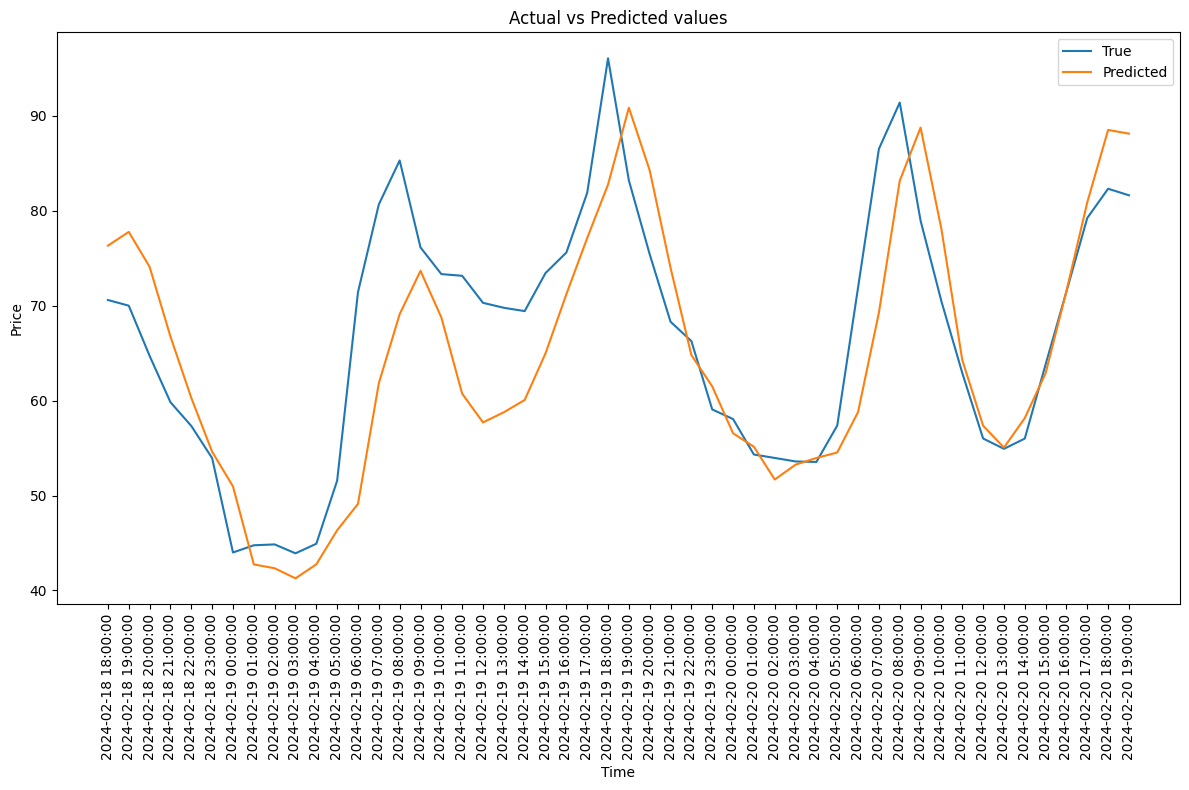

In [78]:
line_plot(output_df.head(50))

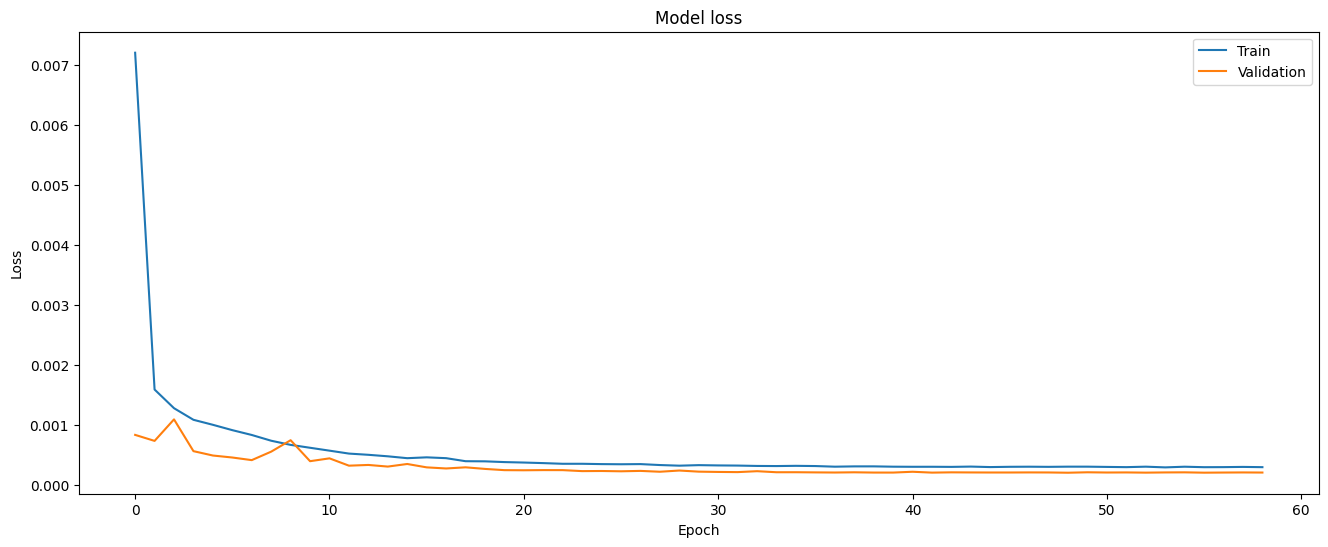

In [79]:
loss_line_plot()